In [15]:
import numpy as np
import scipy.signal
from multiprocessing import Pool
from enum import Enum

class Direction(Enum):
    N = 0
    NE = 1
    E = 2
    SE = 3
    S = 4
    SW = 5
    W = 6
    NW = 7

transform = {
    'N': (0,-1),
    'NE': (1,-1),
    'E': (1,0),
    'SE': (1,1),
    'S': (0,1),
    'SW': (-1,1),
    'W': (-1,0),
    'NW': (-1,-1)
}

"""def _is_border(kernel):
    if kernel[0][1] and kernel[1][0] and kernel[2][1] and kernel[1][2]:
        return True
    else:
        return False"""

# [[0,1,0],
#  [1,1,1],
#  [0,1,0]]

def _form_boundary_mask(mask):
    #padded_mask = np.pad(mask, [(1,1),(1,1)], mode='constant', constant_values=[(1,1),(1,1)])
    #padded_mask_shape = padded_mask.shape
    #boundary_mask = np.zeros(mask.shape,dtype=np.bool_)
    kernel = [[0,1,0],
              [1,5,1],
              [0,1,0]]
    boundary_mask = scipy.signal.convolve2d(mask,kernel,boundary="fill",fillvalue=0.0)
    boundary_mask = (boundary_mask < 9.0) & (boundary_mask > 5.0)
    
    return boundary_mask

def _transform_dir(direction):
    return transform[Direction(direction).name]

def _find_next_dir(boundary_mask,cur_pixel,last_dir):
    next_dir = Direction((Direction[last_dir].value-3)%8).name
    inv_dir = Direction((Direction[last_dir].value-4)%8).name
    
    while True:
        next_pixel = [sum(x) for x in zip(cur_pixel,transform[next_dir])]
        if next_dir == inv_dir:
            return None
        elif boundary_mask[next_pixel[1]][next_pixel[0]] == 1:
            return next_pixel,next_dir
        else:
            next_dir = Direction((Direction[next_dir].value+1)%8).name
    
        

def _find_highest_pixel(boundary):
    if len(np.where(boundary == 1)[0]) > 0:
        y = min(np.where(boundary == 1)[0])
        x = min(np.where(boundary[y] == 1)[0])
        return (x,y)
    else:
        return None
    

def _order_boundary_pixels(boundary):    
    ordered_pixels = []
    
    exists_bounds = True

    cur_pixel = _find_highest_pixel(boundary)
    plt.figure(figsize=(20, 20))
    plt.imshow(boundary,cmap='gray')
    plt.show()
    cv2.imwrite("../boundary.png",boundary*255)
    
    while exists_bounds:
        cur_list = []
        
        cur_list.append(cur_pixel)
        last_dir = "E"
        exists_next = True 

        while exists_next:
            boundary[cur_pixel[1],cur_pixel[0]] = 0.0

            res = _find_next_dir(boundary,cur_pixel,last_dir)
            if not res:
                exists_next = False
            else:
                cur_pixel,last_dir = res
                cur_list.append(cur_pixel)        
        
        ordered_pixels.append(cur_list)
        cur_pixel = _find_highest_pixel(boundary)
        if not cur_pixel:
            exists_bounds = False
    
    return ordered_pixels

def gen_sliding_window(img):
    boundary_mask = _form_boundary_mask(img)
    temp_mask = boundary_mask.copy()
    sliding_window = _order_boundary_pixels(temp_mask)
    
    for group in sliding_window:
        count = 0
        
        for pixel in group[::32]:
            print(pixel)
            square = boundary_mask[pixel[1]-31:pixel[1]+32,pixel[0]-31:pixel[0]+32]
            plt.figure(figsize=(4, 4))
            plt.imshow(square,cmap='gray')
            plt.show()
            

    return sliding_window

(1024, 2048)


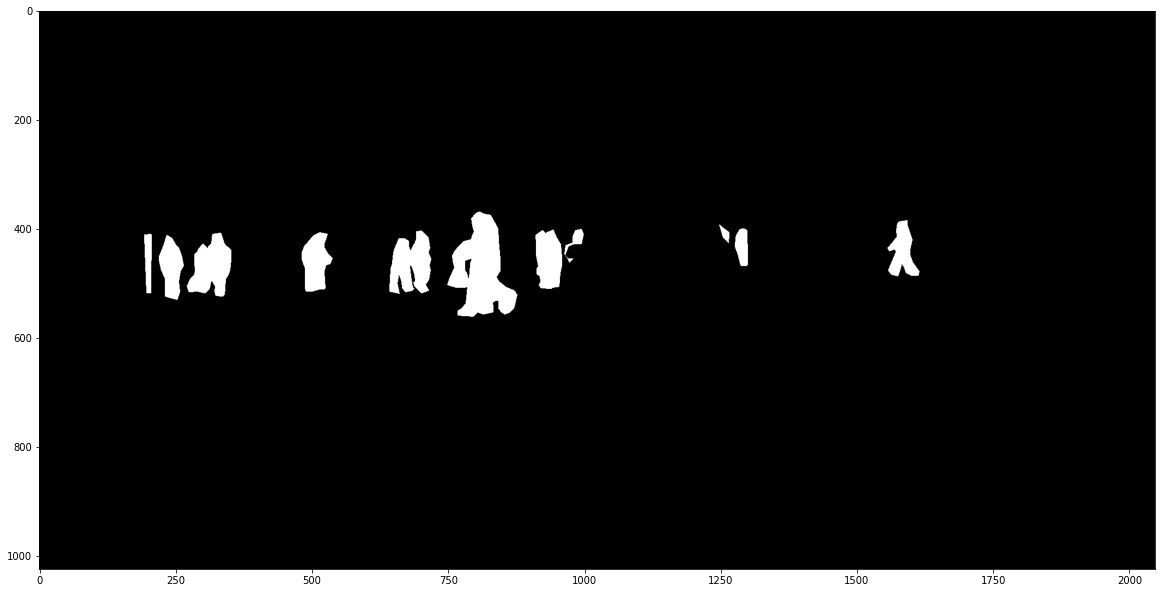

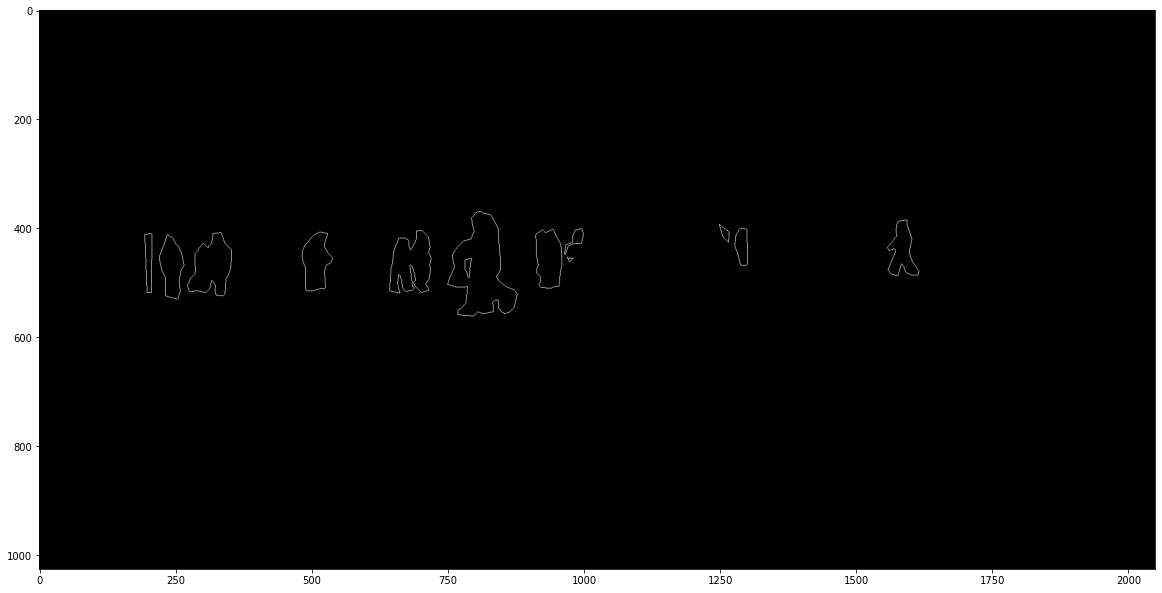

(808, 369)


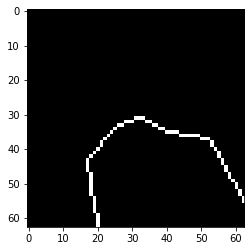

[835, 386]


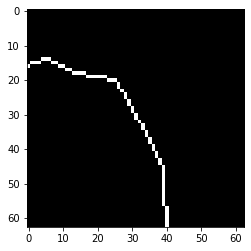

[844, 418]


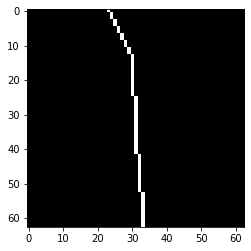

[846, 450]


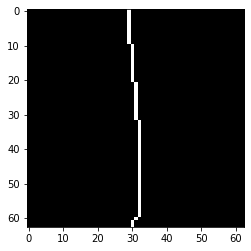

[844, 482]


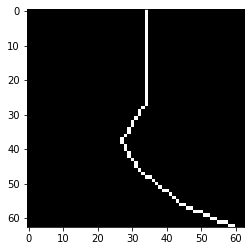

[862, 509]


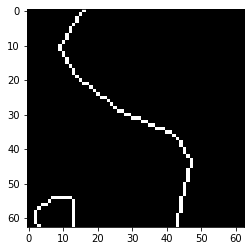

[875, 535]


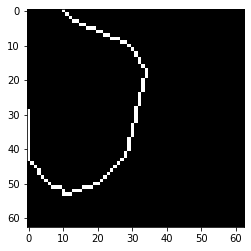

[852, 555]


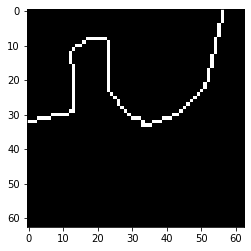

[835, 534]


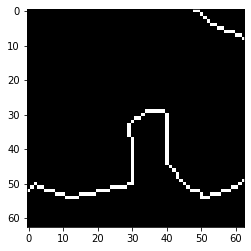

[821, 556]


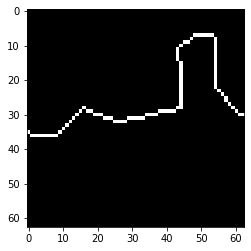

[789, 560]


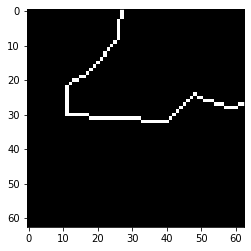

[773, 548]


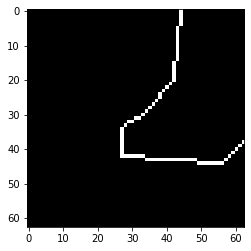

[786, 517]


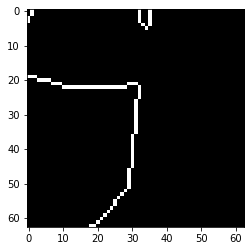

[764, 507]


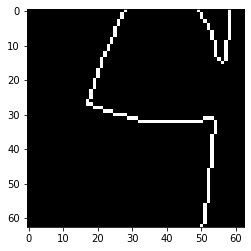

[757, 485]


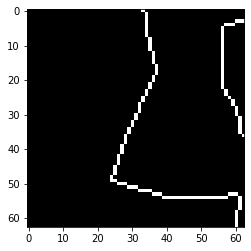

[759, 453]


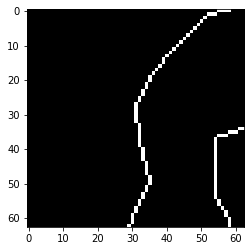

[782, 423]


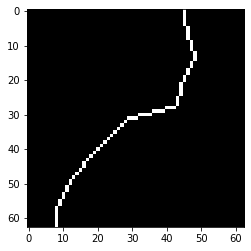

[797, 399]


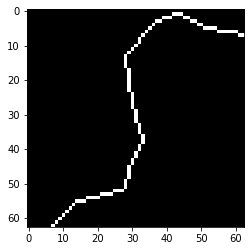

[807, 370]


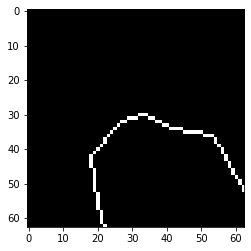

(1590, 385)


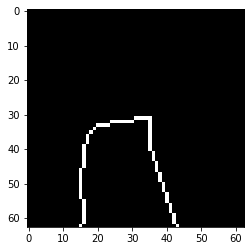

[1601, 413]


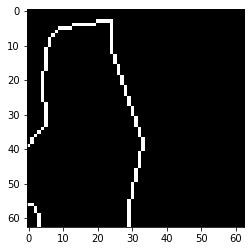

[1599, 445]


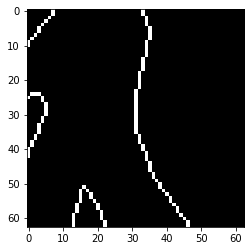

[1615, 477]


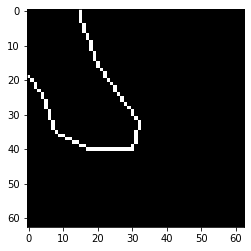

[1591, 480]


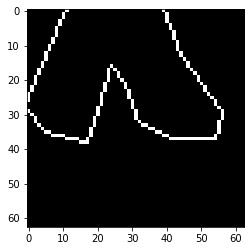

[1579, 482]


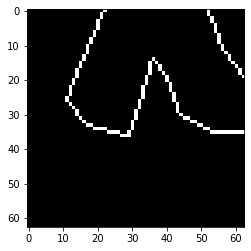

[1562, 469]


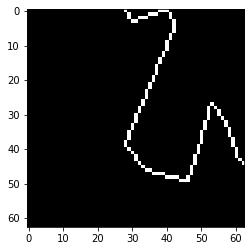

[1570, 438]


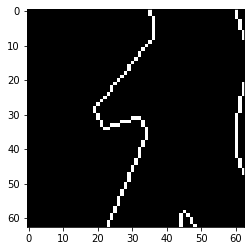

[1572, 418]


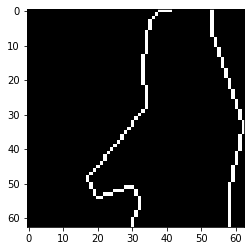

[1580, 387]


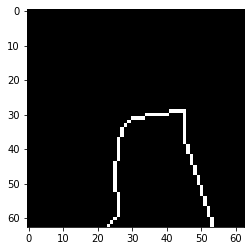

(1249, 393)


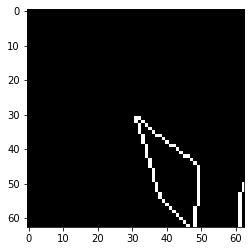

[1266, 421]


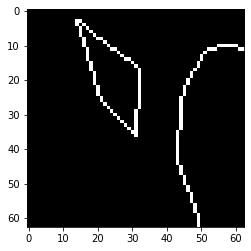

[1251, 399]


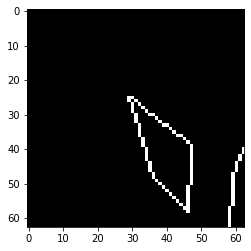

(1290, 400)


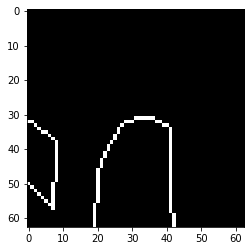

[1300, 425]


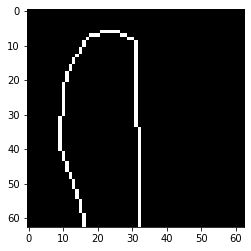

[1301, 457]


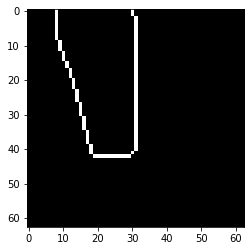

[1286, 457]


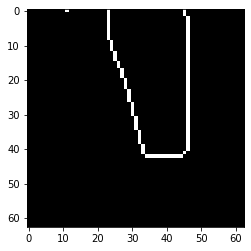

[1278, 425]


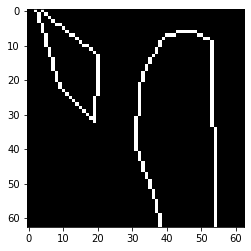

(993, 401)


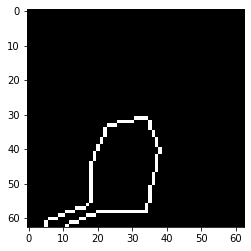

[994, 428]


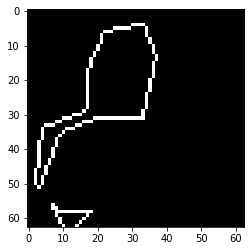

[968, 443]


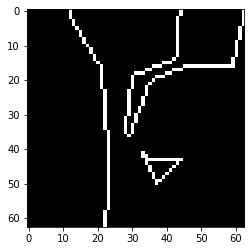

[977, 427]


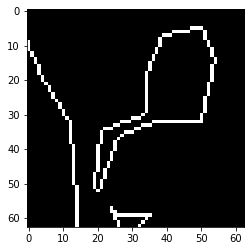

[992, 402]


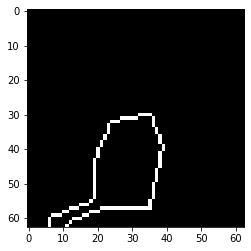

(943, 402)


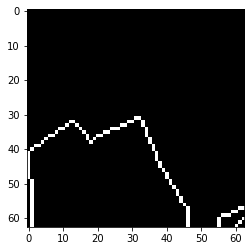

[958, 433]


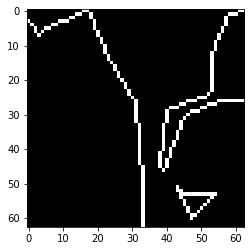

[960, 465]


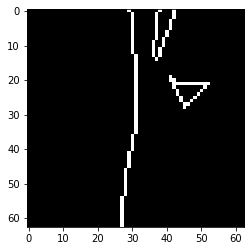

[956, 497]


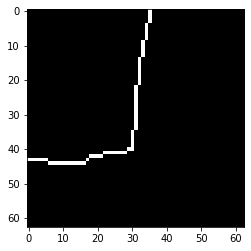

[932, 510]


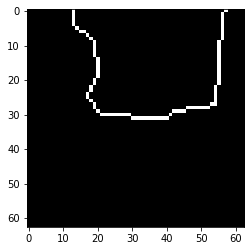

[919, 487]


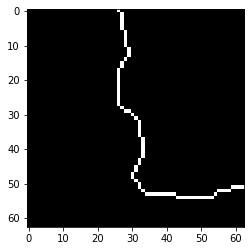

[914, 456]


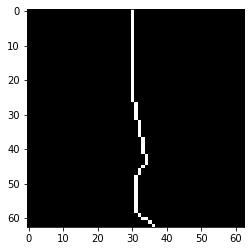

[913, 424]


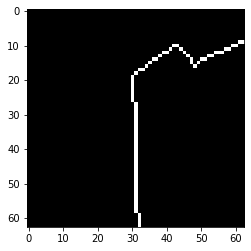

[931, 408]


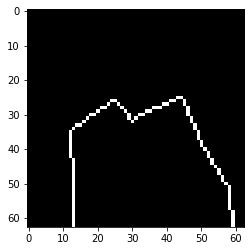

(698, 404)


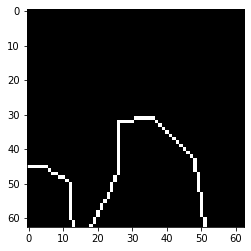

[717, 431]


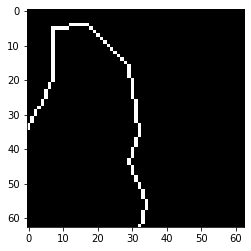

[718, 463]


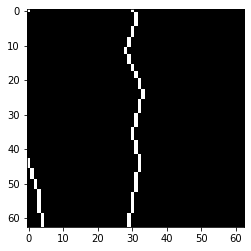

[715, 495]


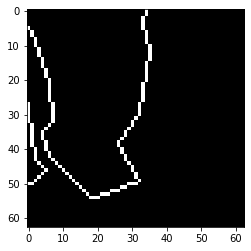

[702, 518]


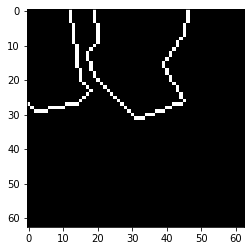

[690, 486]


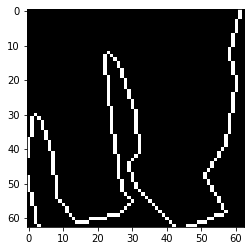

[682, 480]


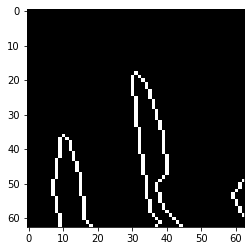

[687, 512]


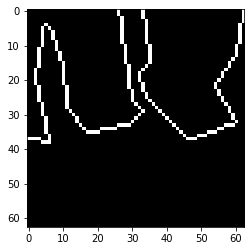

[666, 498]


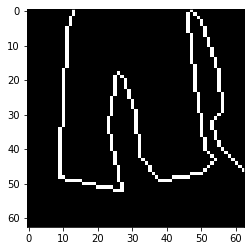

[659, 504]


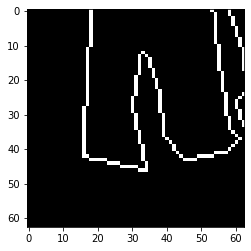

[645, 515]


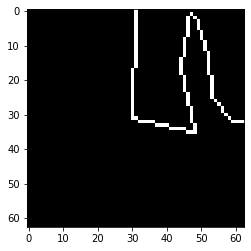

[645, 484]


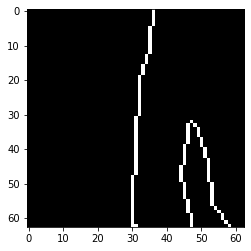

[650, 452]


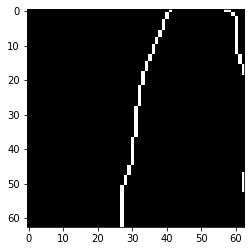

[660, 420]


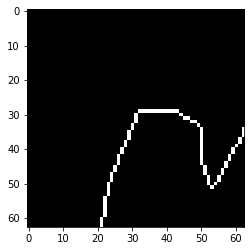

[680, 435]


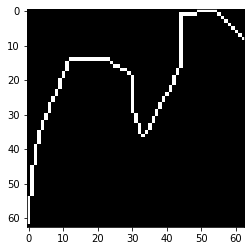

[693, 413]


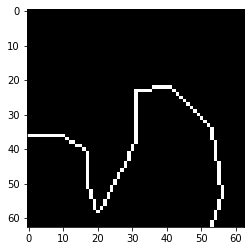

(515, 407)


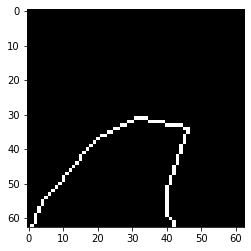

[524, 427]


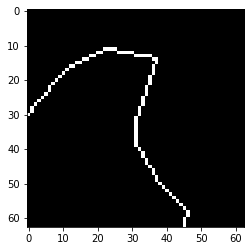

[537, 459]


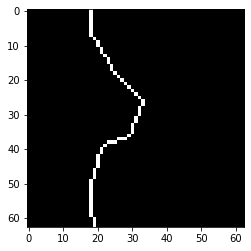

[524, 487]


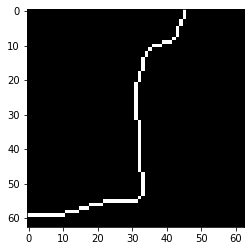

[516, 511]


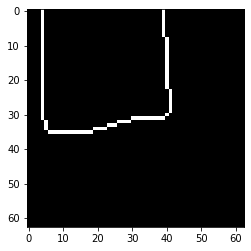

[489, 508]


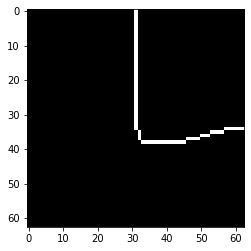

[489, 476]


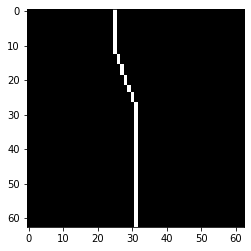

[483, 444]


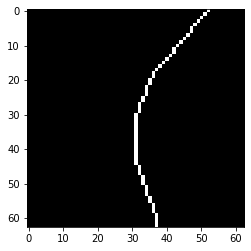

[505, 412]


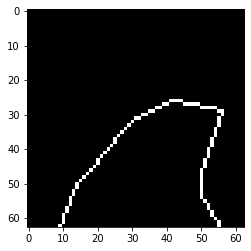

(330, 408)


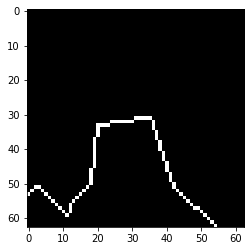

[349, 435]


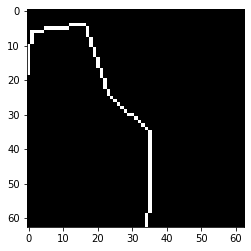

[352, 467]


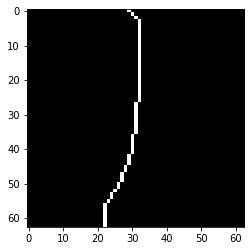

[343, 499]


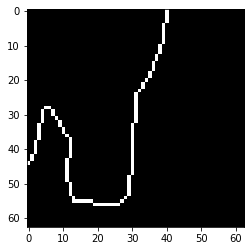

[331, 524]


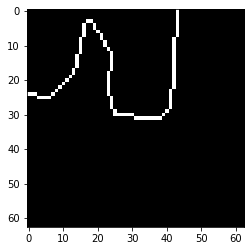

[319, 497]


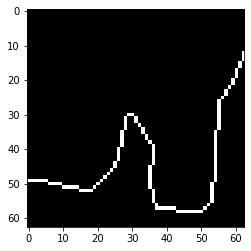

[298, 517]


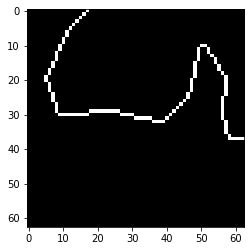

[272, 506]


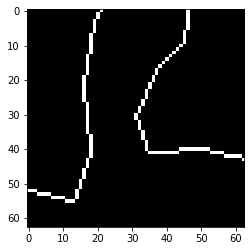

[287, 474]


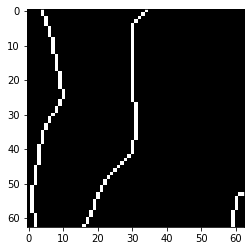

[291, 442]


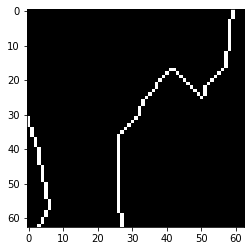

[317, 427]


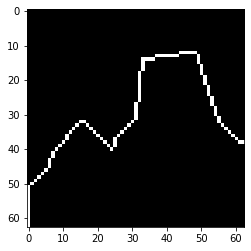

(201, 410)


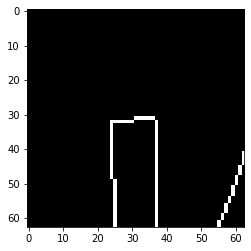

[207, 437]


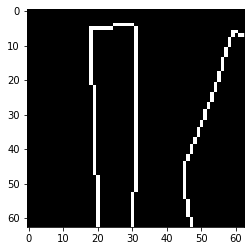

[206, 469]


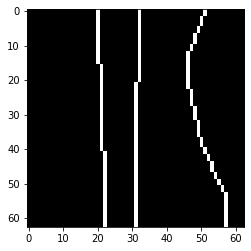

[206, 501]


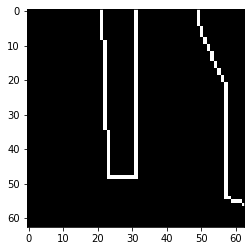

[198, 511]


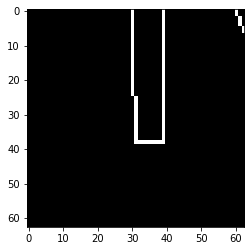

[197, 479]


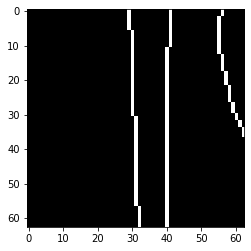

[195, 447]


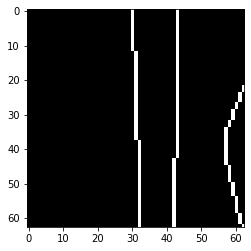

[194, 415]


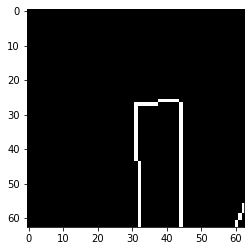

(235, 412)


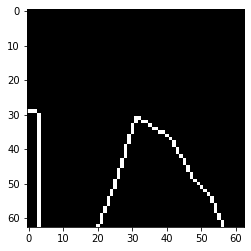

[259, 440]


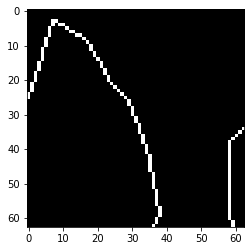

[264, 472]


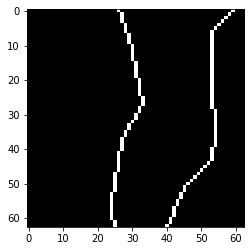

[258, 504]


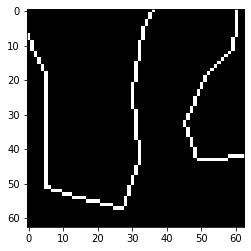

[248, 529]


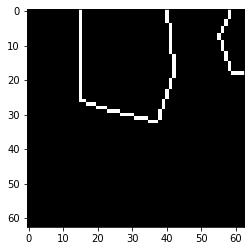

[232, 508]


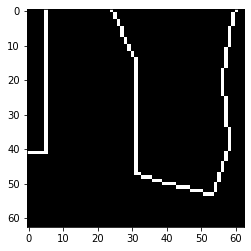

[225, 476]


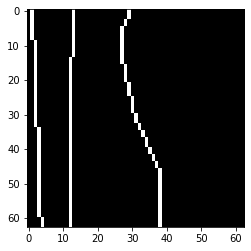

[224, 444]


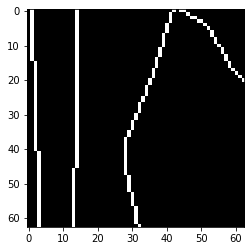

(970, 453)


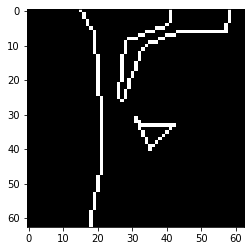

(792, 455)


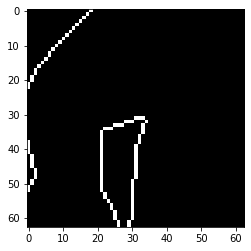

[790, 485]


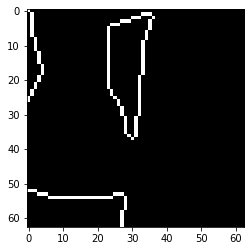

[782, 465]


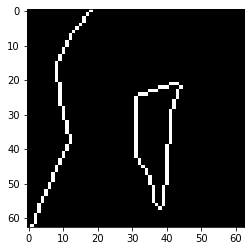

In [16]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread("../img.png",cv2.IMREAD_GRAYSCALE)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.figure(figsize=(20, 20))
plt.imshow(img,cmap='gray')
plt.show()
windows = gen_sliding_window(img/255)
